In [23]:
#%pip install implicit
#%pip install tensorflow
#%pip install py-spy

In [24]:
import sklearn.model_selection
import implicit
from implicit.evaluation import precision_at_k, train_test_split,  ranking_metrics_at_k
from sklearn.metrics import mean_squared_error
from implicit.nearest_neighbours import bm25_weight

import pandas as pd
from data import get_rating_matrix, get_interactions, get_job_data, get_job_interactions_matrix, filter_user_item
from metrices import ARP, ACLT, APLT
import os

import numpy as np
import itertools
import copy
import scipy.sparse as sparse



def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, float):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)

def get_popularity_metrices(model, train, test,  long_tail_items, K=10):
    if not isinstance(train, sparse.csr_matrix):
        train_user_items = train.tocsr()

    if not isinstance(test, sparse.csr_matrix):
        test_user_items = test.tocsr()



    train_items = train.T.row
    users = test_user_items.shape[0]
    items = test_user_items.shape[1]

    user_items_train = train.tocsr()


    # print('users_train', len(users_train))
    # print('items_train', len(items_train))

    test_indptr = test_user_items.indptr
    test_indices = test_user_items.indices

    batch_size = 1000
    start_idx = 0

    # get an array of userids that have at least one item in the test set
    to_generate = np.arange(users, dtype="int32")
    to_generate = to_generate[np.ediff1d(test_user_items.indptr) > 0]
    likes = set()
    total = 0
    arp = 0
    aclt = 0
    aplt = 0
    long_tail = 0
    total_indic = 0
    rec_pop = 0

    while start_idx < len(to_generate):
        batch = to_generate[start_idx: start_idx + batch_size]
        ids, _ = model.recommend(batch, train_user_items[batch], N=K)
        start_idx += batch_size

        for batch_idx in range(len(batch)):
            u = batch[batch_idx]

            likes.clear
            for i in range(test_indptr[u], test_indptr[u+1]):
                likes.add(test_indices[i])


            theta = 0
            if u < batch_size:
                rec_list = ids[u]
                long_tail += len(rec_list[np.in1d(rec_list, long_tail_items)]) / K
                total_indic += sum([1 if item in long_tail_items else 0 for item in rec_list])
                for i in range(K):
                    theta += np.count_nonzero(train_items == ids[batch_idx, i])

                rec_pop += theta / K
                total +=1

    arp = rec_pop / total
    aplt = long_tail / total
    aclt = total_indic / total
    #ids, score = model.recommend(userid=users_train, user_items=user_items_train[users_train], N=K,  filter_already_liked_items = True)
    #print(users_test, len(ids))


    #arp = ARP(recommendations=ids, test_users=users_test, train_items=items_train, k=K)
    #aclt = ACLT(recommendations=ids, test_users=users_test, long_tail_items=long_tail_items, k=K)
    #aplt = APLT(recommendations =ids, test_users= users_test, long_tail_items=long_tail_items, k=K)
    print({'arp': arp, 'aplt': aplt, 'aclt': aclt})

    return {'arp': arp, 'aplt': aplt, 'aclt': aclt}


def learning_curve(model, train, test, long_tail_items, epochs, user_index, k=5, ):

    prev_epoch = 0
    precision = []
    ndcg = []
    auc = []
    map_metric = []
    mse = []
    arp = []
    aclt = []
    aplt = []


    headers = ['epochs', 'p@k', 'auc', 'map', 'ndcg@k']
    #print_log(headers, header=True)

    for epoch in epochs:
        model.iterations = epoch - prev_epoch
        if not hasattr(model, 'user_vectors'):
            model.fit(train.T, show_progress=False)
        else:
            model.fit_partial(train, show_progress=False)
        populaity_metrices = get_popularity_metrices(model, train.T, test.T, long_tail_items)
        metrices = ranking_metrics_at_k(model, train.T, test.T, K=k, show_progress=False)
        #train_mse.append(calculate_mse(model, train, user_index))
        #mse.append(calculate_mse(model, train, user_index))
        #train_precision.append(precision_at_k(model, train, k, user_index))
        precision.append(metrices['precision'])
        ndcg.append(metrices['ndcg'])
        auc.append(metrices['auc'])
        map_metric.append(metrices['map'])

        arp.append(populaity_metrices['arp'])
        aplt.append(populaity_metrices['aplt'])
        aclt.append(populaity_metrices['aclt'])


        #test_mse.append(calculate_mse(model, test, user_index))
        #test_precision.append(precision_at_k(model, test, k, user_index))
        row = [epoch, precision[-1], auc[-1], map_metric[-1], ndcg[-1], ]
        #print_log(row)
        prev_epoch = epoch
    return model, precision, auc, map_metric, ndcg, arp, aclt, aplt

def grid_search_learning_curve(base_model, train, test, param_grid, long_tail_items,
                               user_index=None, patk=5, epochs=range(2, 40, 2)):
    """
    "Inspired" (stolen) from sklearn gridsearch
    https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py
    """
    curves = []
    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        this_model = copy.deepcopy(base_model)
        print_line = []
        for k, v in params.items():
            setattr(this_model, k, v)
            print_line.append((k, v))

        print(' | '.join('{}: {}'.format(k, v) for (k, v) in print_line))
        model, precision, auc, map_metric, ndcg, arp, aclt, aplt = learning_curve(this_model, train, test, long_tail_items,
                                                                epochs, k=patk, user_index=user_index)
        curves.append({'params': params,
                       'patk': precision,
                       'ndcg': ndcg,
                       'map': map_metric,
                       'auc': auc,
                       'arp': arp,
                       'aclt':aclt,
                       'aplt': aplt
                       })
    return curves


def map_ids(row, mapper):
    return mapper[row]

def get_sparse(rating_matrix):


    data = rating_matrix.rating
    U = rating_matrix.uidx.unique()
    V = rating_matrix.iidx.unique()

    print(U, V)

    likes = sparse.coo_matrix((data, (U, V)), dtype=np.float64)
    likes = likes.tocsr()
    return likes  #, idx_to_jid, idx_to_uid


def train_test_split_sparse(ratings_df):

    """
  Args:
    rating_df
  Returns:
    array of user IDs for each row of the ratings matrix
    array of item IDs for each column of the rating matrix
    sparse coo_matrix for training
    sparse coo_matrix for test
    """
    np_users = ratings_df.uidx.to_numpy()
    np_items = ratings_df.iidx.to_numpy()
    unique_users = np.unique(np_users)
    unique_items = np.unique(np_items)

    n_users = unique_users.shape[0]
    n_items = unique_items.shape[0]

    # make indexes for users and items if necessary
    max_user = unique_users[-1]
    max_item = unique_items[-1]
    if n_users != max_user or n_items != max_item:
        # make an array of 0-indexed unique user ids corresponding to the dataset
        # stack of user ids
        z = np.zeros(max_user+1, dtype=int)
        z[unique_users] = np.arange(n_users)
        u_r = z[np_users]

        # make an array of 0-indexed unique item ids corresponding to the dataset
        # stack of item ids
        z = np.zeros(max_item+1, dtype=int)
        z[unique_items] = np.arange(n_items)
        i_r = z[np_items]

        # construct the ratings set from the three stacks
        np_ratings = ratings_df.rating.to_numpy()
        ratings = np.zeros((np_ratings.shape[0], 3), dtype=object)
        ratings[:, 0] = u_r
        ratings[:, 1] = i_r
        ratings[:, 2] = np_ratings
    else:
        ratings = ratings_df.as_matrix(['user_id', 'item_id', 'rating'])
        # deal with 1-based user indices
        ratings[:, 0] -= 1
        ratings[:, 1] -= 1

    tr_sparse, test_sparse = _create_sparse_train_and_test(ratings,
                                                            n_users, n_items)

    train_normal = pd.DataFrame({'userId': tr_sparse.row, 'itemId': tr_sparse.col, 'rating': tr_sparse.data}
                 )[['userId', 'itemId', 'rating']].sort_values(['userId', 'itemId']
                 ).reset_index(drop=True)

    test_normal = pd.DataFrame({'userId': test_sparse.row, 'itemId': test_sparse.col, 'rating': test_sparse.data}
                 )[['userId', 'itemId', 'rating']].sort_values(['userId', 'itemId']
                 ).reset_index(drop=True)

    return ratings[:, 0], ratings[:, 1], tr_sparse, test_sparse, train_normal, test_normal

def _create_sparse_train_and_test(ratings, n_users, n_items):
  """Given ratings, create sparse matrices for train and test sets.
  Args:
    ratings:  list of ratings tuples  (u, i, r)
    n_users:  number of users
    n_items:  number of items
  Returns:
     train, test sparse matrices in scipy coo_matrix format.
  """
  # pick a random test set of entries, sorted ascending
  test_set_size = int(len(ratings) / 10)
  test_set_idx = np.random.choice(range(len(ratings)),
                                  size=test_set_size, replace=False)
  test_set_idx = sorted(test_set_idx)

  # sift ratings into train and test sets
  ts_ratings = ratings[test_set_idx]
  tr_ratings = np.delete(ratings, test_set_idx, axis=0)

  # create training and test matrices as coo_matrix's
  u_tr, i_tr, r_tr = zip(*tr_ratings)
  tr_sparse = sparse.coo_matrix((r_tr, (u_tr, i_tr)), shape=(n_users, n_items))

  u_ts, i_ts, r_ts = zip(*ts_ratings)
  test_sparse = sparse.coo_matrix((r_ts, (u_ts, i_ts)), shape=(n_users, n_items))

  return tr_sparse, test_sparse

def get_sparse_rating_matrix(ratings_df):
    np_users = ratings_df.uidx.to_numpy()
    np_items = ratings_df.iidx.to_numpy()
    unique_users = np.unique(np_users)
    unique_items = np.unique(np_items)

    n_users = unique_users.shape[0]
    n_items = unique_items.shape[0]

    # make indexes for users and items if necessary
    max_user = unique_users[-1]
    max_item = unique_items[-1]
    if n_users != max_user or n_items != max_item:
        # make an array of 0-indexed unique user ids corresponding to the dataset
        # stack of user ids
        z = np.zeros(max_user+1, dtype=int)
        z[unique_users] = np.arange(n_users)
        u_r = z[np_users]

        # make an array of 0-indexed unique item ids corresponding to the dataset
        # stack of item ids
        z = np.zeros(max_item+1, dtype=int)
        print(np.arange(n_items))
        z[unique_items] = np.arange(n_items)
        i_r = z[np_items]

        # construct the ratings set from the three stacks
        np_ratings = ratings_df.rating.to_numpy()
        ratings = np.zeros((np_ratings.shape[0], 3), dtype=object)
        ratings[:, 0] = u_r
        ratings[:, 1] = i_r
        ratings[:, 2] = np_ratings

    u, i, r = zip(*ratings)
    sparse_rating = sparse.coo_matrix((r, (u, i)), shape=(n_users, n_items))
    return sparse_rating

In [25]:
rating_matrix = pd.read_csv('./data/ratings-filtered-90-days.csv')
item_feature_df = pd.read_csv('./data/item_feature-filtered-90-days.csv')
#rating_matrix.rating = 1

In [26]:
#train, test, n_users, n_items = prepare_data_for_esam(rating_matrix.rename(columns={'userId': 'user_id', 'itemId': 'item_id'}))
userids, itemids, train, test, train_dense, test_dense  = train_test_split_sparse(rating_matrix[['uidx', 'iidx', 'rating']])

In [27]:
sparse_rating = get_sparse_rating_matrix(rating_matrix[['uidx', 'iidx', 'rating']])
sparse_rating

[   0    1    2 ... 3404 3405 3406]


<4365x3407 sparse matrix of type '<class 'numpy.int32'>'
	with 43287 stored elements in COOrdinate format>

In [28]:
#rating_matrix_2 = threshold_likes(rating_matrix, 20)#%%
#likes, idx_to_jid, idx_to_uid  = get_likes(rating_matrix_2)
#train, test, user_index = train_test_split(ratings = likes, split_count = 3, user_index=rating_matrix_2.userId.unique())
#train2, test2 = implicit.evaluation.train_test_split(train)

In [29]:
print('number of users in train', train_dense.userId.nunique(), np.unique(train.row))
print('number of items in train', train_dense.itemId.nunique(), np.unique(train.T.row))


param_grid = {'factors': [10, 20, 40, 80, 120],
              'regularization': [0.0, 1e-5, 1e-3, 1e-1,1e1, 1e2 ]
              }

base_model = implicit.als.AlternatingLeastSquares()

long_tail_items = item_feature_df[item_feature_df.feature == 'long_tail'].iidx

curves = grid_search_learning_curve(base_model, train.T, test.T,
                                    param_grid, long_tail_items=long_tail_items,
                                    patk=10)

number of users in train 4365 [   0    1    2 ... 4362 4363 4364]
number of items in train 3407 [   0    1    2 ... 3404 3405 3406]
factors: 10 | regularization: 0.0
{'arp': 49.48555900621116, 'aplt': 0.0023291925465838514, 'aclt': 3.200310559006211}
{'arp': 55.42546583850934, 'aplt': 0.003105590062111802, 'aclt': 3.0419254658385095}
{'arp': 54.88260869565222, 'aplt': 0.002484472049689441, 'aclt': 3.1847826086956523}
{'arp': 54.25248447204976, 'aplt': 0.002484472049689441, 'aclt': 3.2841614906832297}
{'arp': 53.785403726708125, 'aplt': 0.002950310559006212, 'aclt': 3.3229813664596275}
{'arp': 53.41863354037274, 'aplt': 0.003260869565217392, 'aclt': 3.4114906832298137}
{'arp': 53.04083850931683, 'aplt': 0.0029503105590062122, 'aclt': 3.436335403726708}
{'arp': 52.87717391304353, 'aplt': 0.003105590062111802, 'aclt': 3.4736024844720497}
{'arp': 52.833695652173915, 'aplt': 0.0026397515527950316, 'aclt': 3.4736024844720497}
{'arp': 52.80916149068323, 'aplt': 0.0027950310559006217, 'aclt': 

{'factors': 120, 'regularization': 1e-05}
0.1550081338600976
Epoch: 12


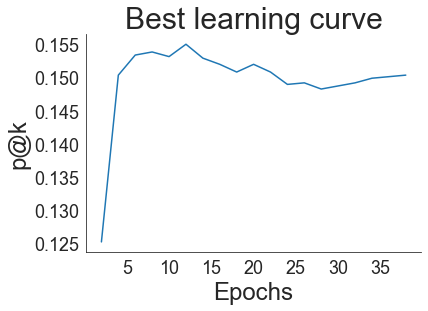

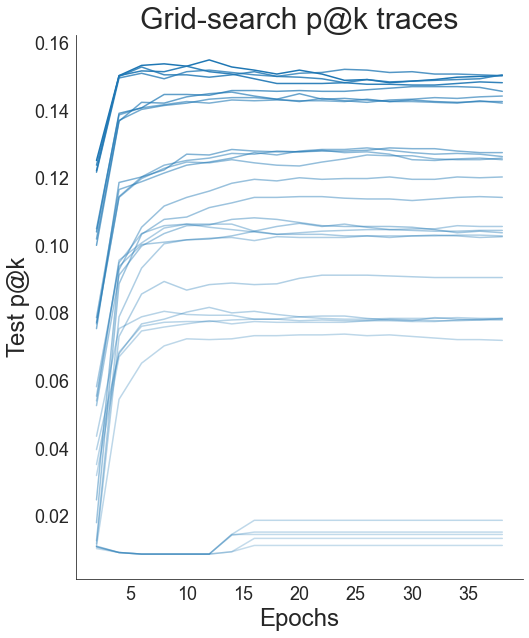

In [30]:
best_curves = sorted(curves, key=lambda x: max(x['patk']), reverse=True)

print(best_curves[0]['params'])
max_score = max(best_curves[0]['patk'])
print(max_score)
iterations = range(2, 40, 2)[best_curves[0]['patk'].index(max_score)]
print('Epoch: {}'.format(iterations))
epochs = range(2, 40, 2)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
fig, ax = plt.subplots()
sns.despine(fig);
plt.plot(epochs, best_curves[0]['patk']);
plt.xlabel('Epochs', fontsize=24);
plt.ylabel('p@k', fontsize=24);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title('Best learning curve', fontsize=30);# %%
# %%
all_test_patks = [x['patk'] for x in best_curves]
fig, ax = plt.subplots(figsize=(8, 10));
sns.despine(fig);
epochs = range(2, 40, 2)
totes = len(all_test_patks)
for i, patk in enumerate(all_test_patks):
    ax.plot(epochs, patk,
             alpha=1/(.1*i+1),
             c=sns.color_palette()[0]);

plt.xlabel('Epochs', fontsize=24);
plt.ylabel('Test p@k', fontsize=24);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title('Grid-search p@k traces', fontsize=30);

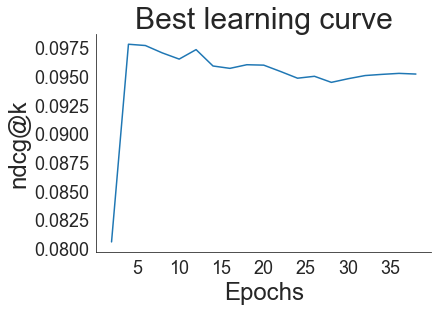

In [31]:
sns.set_style('white')
fig, ax = plt.subplots()
sns.despine(fig);
plt.plot(epochs, best_curves[0]['ndcg']);
plt.xlabel('Epochs', fontsize=24);
plt.ylabel('ndcg@k', fontsize=24);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title('Best learning curve', fontsize=30);

[34.67919254658384, 28.648291925465845, 27.662422360248435, 27.16661490683229, 27.022826086956513, 26.92795031055901, 26.90885093167704, 26.936956521739138, 26.86599378881987, 26.887577639751534, 26.94378881987576, 26.95372670807452, 26.95232919254656, 26.992701863353997, 27.009316770186295, 27.003881987577593, 27.04487577639748, 27.045496894409904, 27.029037267080728]


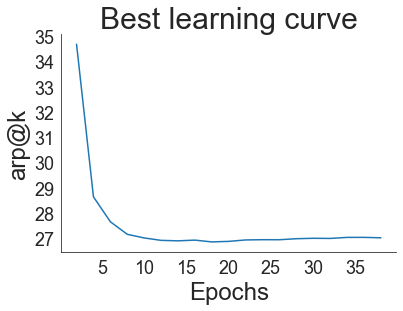

In [32]:
print(best_curves[0]['arp'])
sns.set_style('white')
fig, ax = plt.subplots()
sns.despine(fig);
plt.plot(epochs, best_curves[0]['arp']);
plt.xlabel('Epochs', fontsize=24);
plt.ylabel('arp@k', fontsize=24);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title('Best learning curve', fontsize=30);

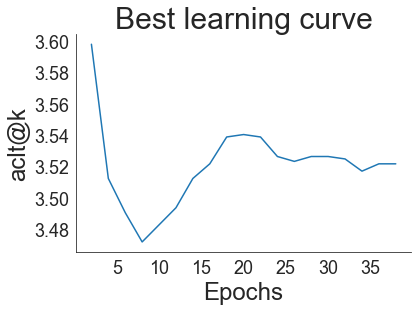

In [33]:
sns.set_style('white')
fig, ax = plt.subplots()
sns.despine(fig);
plt.plot(epochs, best_curves[0]['aclt']);
plt.xlabel('Epochs', fontsize=24);
plt.ylabel('aclt@k', fontsize=24);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title('Best learning curve', fontsize=30);

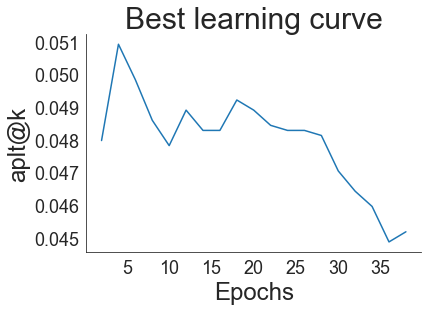

In [34]:
sns.set_style('white')
fig, ax = plt.subplots()
sns.despine(fig);
plt.plot(epochs, best_curves[0]['aplt']);
plt.xlabel('Epochs', fontsize=24);
plt.ylabel('aplt@k', fontsize=24);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title('Best learning curve', fontsize=30);

In [35]:
params = best_curves[0]['params']
params['iterations'] = range(2, 40, 2)[best_curves[0]['patk'].index(max_score)]
bestALS = implicit.als.AlternatingLeastSquares(**params)
bestALS.fit(sparse_rating)

  0%|          | 0/12 [00:00<?, ?it/s]

In [36]:
users = rating_matrix.uidx.unique()
#print(len(np.unique(train.T.row)))

ids, score = bestALS.recommend(userid=users, user_items=sparse_rating.tocsr()[users], N=100,  filter_already_liked_items = True)

#itemsIds, score = best_model.rank_items(userid=users, user_items=test.tocsr()[0], selected_items=ids[users])


data = []

for i in range(len(users)):
    data.append({'userId': users[i], 'itemId': ids[i], 'score': score[i]})

df = pd.DataFrame(data)
ranking_df = df.set_index(['userId']).apply(pd.Series.explode).reset_index()

In [37]:
#ranking_df.to_csv('./data/outputs/output-implicit_als.data')

#ranking_df = pd.read_csv('./data/outputs/output-implicit_als.data', index_col=0)



In [38]:
item_pop = rating_matrix.groupby(['iidx']).count().sort_values('uidx', ascending=False)['uidx']
head_tail_items = item_feature_df[item_feature_df.feature == 'short_head'].iidx.to_numpy()
long_tail_items = item_feature_df[item_feature_df.feature == 'long_tail'].iidx.to_numpy()

# %%
predictions = ranking_df.copy()
from xQuAD.xQuAD import RankerXQuad
from xQuAD.Model import save_obj

lmbdas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#lmbdas = [0.4]
users = list(np.unique(rating_matrix['uidx'].values))
items = list(np.unique(rating_matrix['iidx'].values))

predictions = ranking_df.pivot(index='userId', columns='itemId', values = 'score').fillna(0)
predictions = predictions.reindex(index=users, columns=items, fill_value=0).values
models = {}
model = RankerXQuad(users = users, items = items, observed_relevance = train_dense, unobserved_relevance = test_dense, item_field = 'itemId', rating_field='rating', user_field = 'userId', item_feature_df=item_feature_df)


for lmbda in lmbdas:
    print("Training with ", {'lambda': lmbda})
    model.set_predictions(predictions)
    model.rerank(type='smooth', lmbda=lmbda, k=10, rmax=100)
    scores = model.get_predictions()
    save_obj(scores, os.path.join('./data/outputs/scores/implicit/reranker-implicit' + str(lmbda) + '_scores.pkl'))
    model.test()

    metrics = model.get_metrics()
    save_obj(metrics, os.path.join('././data/outputs/metrics//implicit/reranker-implicit' + str(lmbda) + '_metrics.pkl'))
    model.show_metrics()
    models[lmbda] = model

Initializing user and  item lists
Initializing observed, unobserved, and predicted relevance scores
Initializing item popularity lists
Initializing metrics
Training with  {'lambda': 0.0}
0.0
Computing metrics for user 4365 / 4365365 4365 4365 4365 436543651881 / 43654365/ 43652403 / 4365 43652575 / 43652708 / 43652927 / 43654365 3103 / 4365/ 43653843 / 4365 4365
4365
2909.0
Precision: 0.0 
Recall: 0.0 
NDCG: 0.0 
Hit Rate: 0.0 
Avg Popularity: 24.8515 
Category Diversity: 0.0 
Novelty: 7.7773 
Item Coverage: 0.49 
User Coverage: 0.0 
ARP 24.8515 
APLT 0.0666 
ACLT 0.6664
Training with  {'lambda': 0.1}
0.1
Computing metrics for user 4365 / 436536527 / 4365208 / 4365/ 43654365/ 43654365 4365/ 43654365 4365/ 4365 2392 / 43653661 / 43654365 4365 4365
4365
23368.0
Precision: 0.0001 
Recall: 0.0005 
NDCG: 0.0004 
Hit Rate: 0.0009 
Avg Popularity: 8.6249 
Category Diversity: 0.0 
Novelty: 9.2464 
Item Coverage: 0.04 
User Coverage: 0.0009 
ARP 8.6249 
APLT 0.5353 
ACLT 5.3535
Training with  {

C:\Users\perni\Documents\NTNU\Master\Master-Popularity-Bias-In-JobRecs\xQuAD\xQuAD.py:40: RuntimeWarning: invalid value encountered in subtract
  user_scores = (user_scores - min(user_scores)) / (max(user_scores) - min(user_scores))
C:\Users\perni\Documents\NTNU\Master\Master-Popularity-Bias-In-JobRecs\xQuAD\xQuAD.py:40: RuntimeWarning: invalid value encountered in true_divide
  user_scores = (user_scores - min(user_scores)) / (max(user_scores) - min(user_scores))


In [39]:
predictions = ranking_df
# not_rec = {}
# index = 0
# for i in range(0, len(users)):
#     if not i in ranking_df.itemId.unique():
#         predictions = predictions.append({'userId': int(0), 'itemId': int(i), 'score': 0.0}, ignore_index = True)


predictions.userId = predictions.userId.astype(int)
predictions.itemId = predictions.itemId.astype(int)

In [40]:
rating_matrix.iidx.nunique(), rating_matrix.uidx.nunique(), len(predictions), len(predictions[0])

KeyError: 0

In [ ]:
# %%
def unpivot(frame):

    N, K = frame.shape

    data = {

        "score": frame.to_numpy().ravel("F"),

        "itemId": np.asarray(frame.columns).repeat(N),

        "userId": np.tile(np.asarray(frame.index), K),

    }

    return pd.DataFrame(data, columns=["userId", "itemId", "score"])
# %%
reranked_df = unpivot(pd.DataFrame(model.get_predictions()))
user = 0
for item in reranked_df[(reranked_df.score.gt(0) ) & (reranked_df.userId == user)].sort_values(by=['userId', 'score'], ascending=[True, False]).itemId.values:
    print('reranked', item, item_feature_df[item_feature_df.iidx == item].feature.values)
# %%
model.test()
# %%
model.show_metrics(index_k=10)
# %%
reranked_df
# %%
np.argsort(-predictions)[0]
# %%
reranked_df[(reranked_df.score.gt(0) ) & (reranked_df.userId == 0)].sort_values(by=['userId', 'score'], ascending=[True, False])
# %%
# %%
np.savetxt('./data/predictions.txt', predictions)

In [ ]:
train_dense.to_csv('./data/train_dense.data')
test_dense.to_csv('./data/test_dense.data')

In [ ]:
predictions = np.loadtxt('./data/predictions.txt')

# %%
train_dense = pd.read_csv('./data/train_dense.data')
test_dense = pd.read_csv('./data/test_dense.data')
# %%
train_dense[train_dense.itemId == 1915].count()

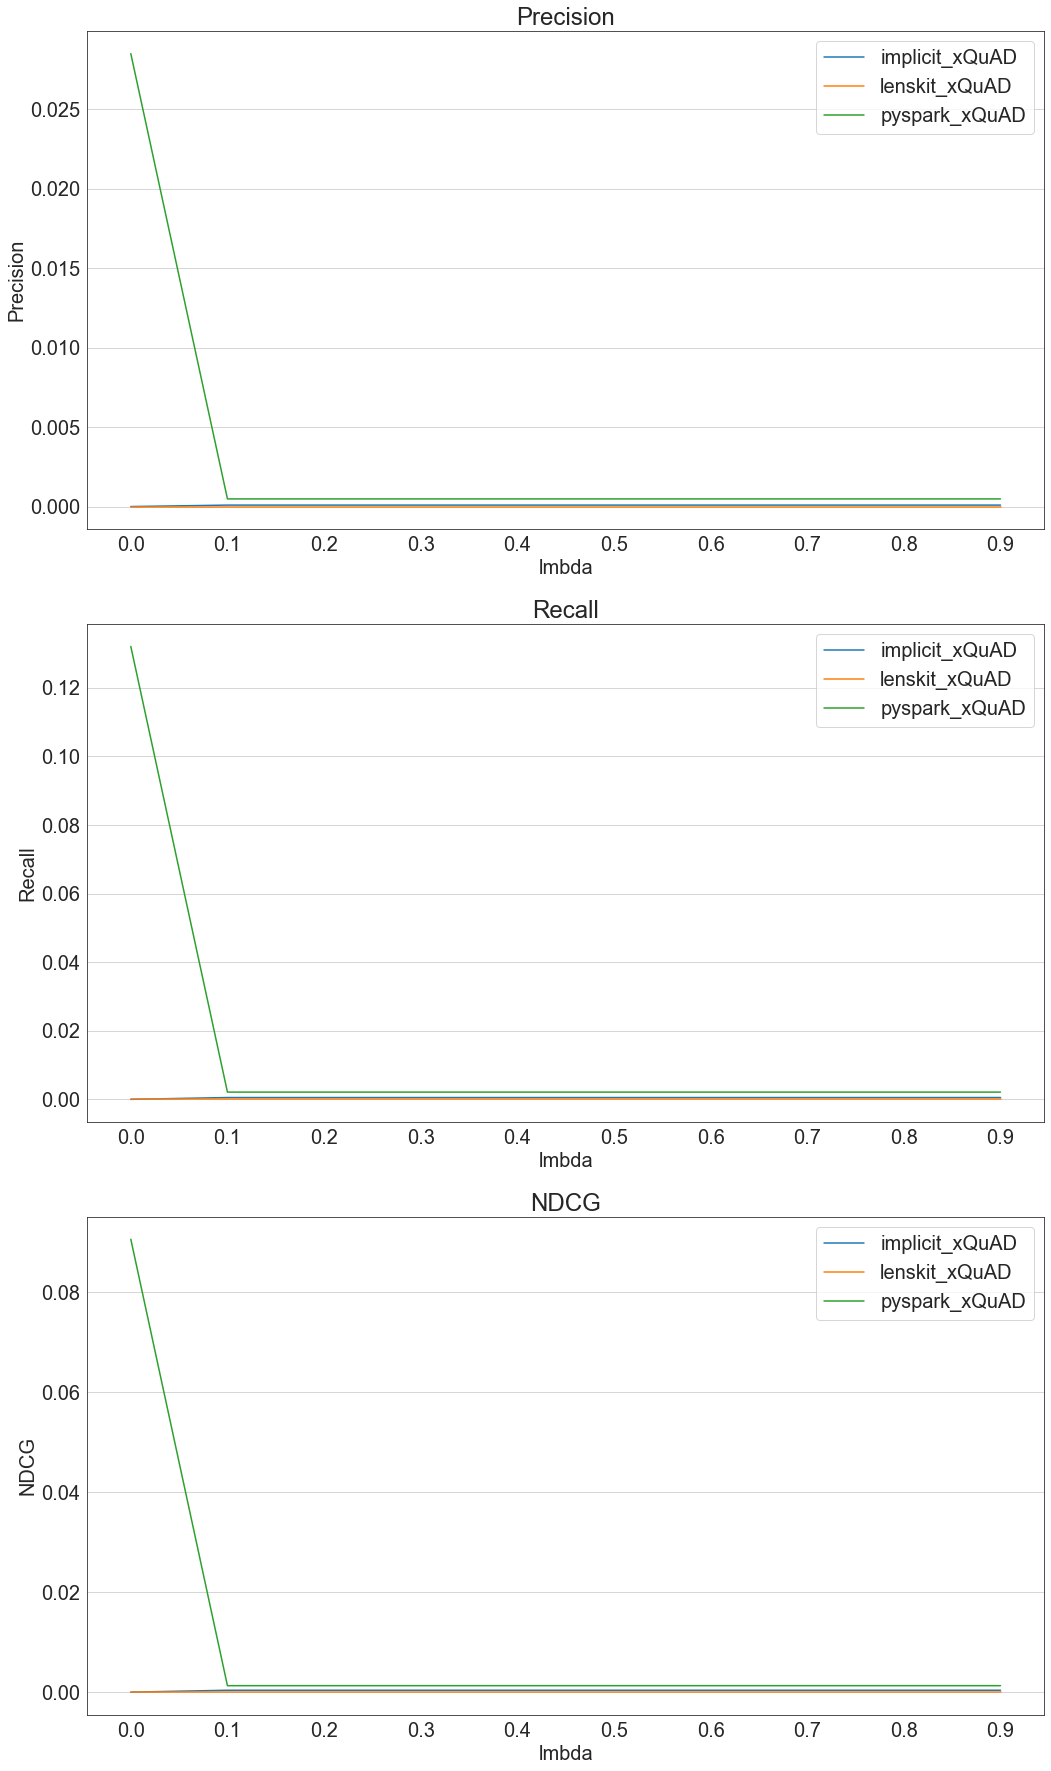

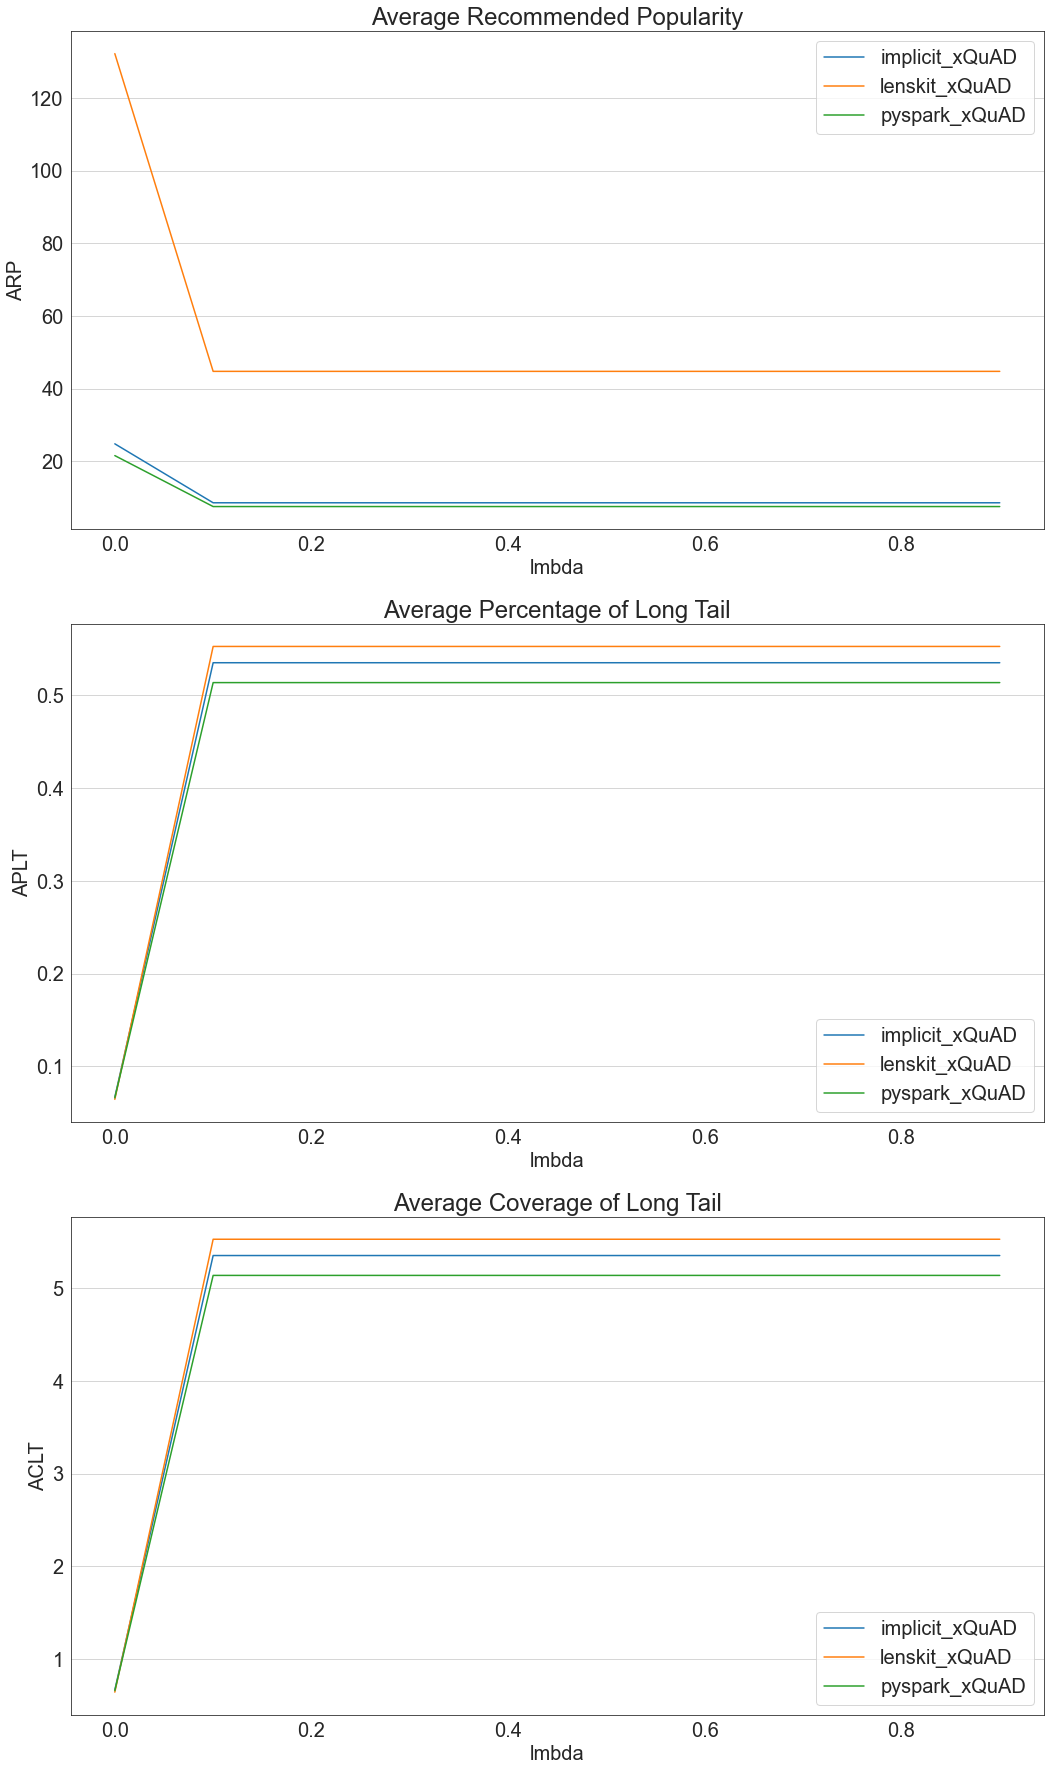

In [103]:

# %%


def plot_effectiveness(metrics, lmbdas, k = 0):
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(15, 25))
    models = ['implicit', 'lenskit', 'pyspark']

    recalls = {'implicit': {}, 'lenskit': {}, 'pyspark': {}}
    precisions = {'implicit': {}, 'lenskit': {}, 'pyspark': {}}
    ndcgs = {'implicit': {}, 'lenskit': {}, 'pyspark': {}}

    for model_type in models:
        for lmbda in lmbdas:
            precisions[model_type][lmbda] = metrics[model_type][lmbda]['precision'][0]
            recalls[model_type][lmbda] = metrics[model_type][lmbda]['recall'][0]
            ndcgs[model_type][lmbda ] = metrics[model_type][lmbda]['ndcg'][0]

    plt.subplot(311)
    plt.title(r'Precision')
    plt.xlabel('lmbda')
    plt.ylabel('Precision')

    for model_type in models:
        plt.plot(lmbdas, [np.mean(precisions[model_type][lmbda]) for lmbda in lmbdas], label=model_type + '_xQuAD')

    plt.xticks(lmbdas)
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(312)
    plt.title(r'Recall')
    plt.xlabel('lmbda')
    plt.ylabel('Recall')
    for model_type in models:
        plt.plot(lmbdas, [np.mean(recalls[model_type][lmbda]) for lmbda in lmbdas], label=model_type+'_xQuAD')

    plt.xticks(lmbdas)
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(313)
    plt.title(r'NDCG')
    plt.xlabel('lmbda')
    plt.ylabel('NDCG')
    for model_type in models:
        plt.plot(lmbdas,  [np.mean(ndcgs[model_type][lmbda])for lmbda in lmbdas], label=model_type+'_xQuAD')
    plt.xticks(lmbdas)
    plt.legend()
    plt.grid(axis='y')

    plt.tight_layout()
    plt.savefig('./figs/results-effectivness.png')



def plot_item_related_metrics(metrics, lmbda):
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(15, 25))
    models = ['implicit', 'lenskit', 'pyspark']

    arps = {'implicit': {}, 'lenskit': {}, 'pyspark': {}}
    aplts = {'implicit': {}, 'lenskit': {}, 'pyspark': {}}
    aclts = {'implicit': {}, 'lenskit': {}, 'pyspark': {}}

    for model_type in ['implicit', 'lenskit', 'pyspark']:
        for lmbda in lmbdas:
            arps[model_type][lmbda] = metrics[model_type][lmbda]['ARP'][0]
            aplts[model_type][lmbda] = metrics[model_type][lmbda]['APLT'][0]
            aclts[model_type][lmbda ] = metrics[model_type][lmbda]['ACLT'][0]

    plt.subplot(311)
    plt.title(r'Average Recommended Popularity')
    plt.xlabel('lmbda')
    plt.ylabel('ARP')

    for model_type in models:
        plt.plot(lmbdas, [np.mean(arps[model_type][lmbda]) for lmbda in lmbdas], label=model_type+'_xQuAD')

    plt.legend()
    plt.grid(axis='y')

    plt.subplot(312)
    plt.title(r'Average Percentage of Long Tail')
    plt.xlabel('lmbda')
    plt.ylabel('APLT')
    for model_type in models:
        plt.plot(lmbdas, [np.mean(aplts[model_type][lmbda]) for lmbda in lmbdas], label=model_type+'_xQuAD')

    plt.legend()
    plt.grid(axis='y')

    plt.subplot(313)
    plt.title(r'Average Coverage of Long Tail')
    plt.xlabel('lmbda')
    plt.ylabel('ACLT')

    for model_type in models:
        plt.plot(lmbdas, [np.mean(aclts[model_type][lmbda]) for lmbda in lmbdas], label=model_type+'_xQuAD')


    plt.legend()
    plt.grid(axis='y')

    plt.tight_layout()
    plt.savefig('./figs/results-popmetrics.png')

lmbdas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

metrics_results = {'implicit': {}, 'pyspark': {}, 'lenskit': {}}
for lmbda in lmbdas:
    implicit_metrics = pd.read_pickle('./data/outputs/metrics/implicit/reranker-implicit' + str(lmbda) + '_metrics.pkl')
    lenskit_metrics = pd.read_pickle('././././data/outputs/metrics/lenskit/reranker-lenskit-' + str(lmbda) + '_metrics.pkl')
    pyspark_metrics = pd.read_pickle('././././data/outputs/metrics/pyspark/reranker-pyspark' + str(lmbda) + '_metrics.pkl')
    metrics_results['implicit'][lmbda] =implicit_metrics
    metrics_results['pyspark'][lmbda] = pyspark_metrics
    metrics_results['lenskit'][lmbda] = lenskit_metrics


plot_effectiveness(metrics_results, lmbdas)
plot_item_related_metrics(metrics_results, lmbda)



# %%

In [74]:

data = {
              'model': ['implicit', 'pyspark'],
              'arp': [34.68, 24.60], 'aplt': [0.048,  0.041],
              'aclt': [3.598, 0.4071],
              'precission': [0.0975,  0.9389],
              'recall': [0, 0.0032],
               'ndcg': [0.0975, 0.9463 ]
}

results = pd.DataFrame(data = data)

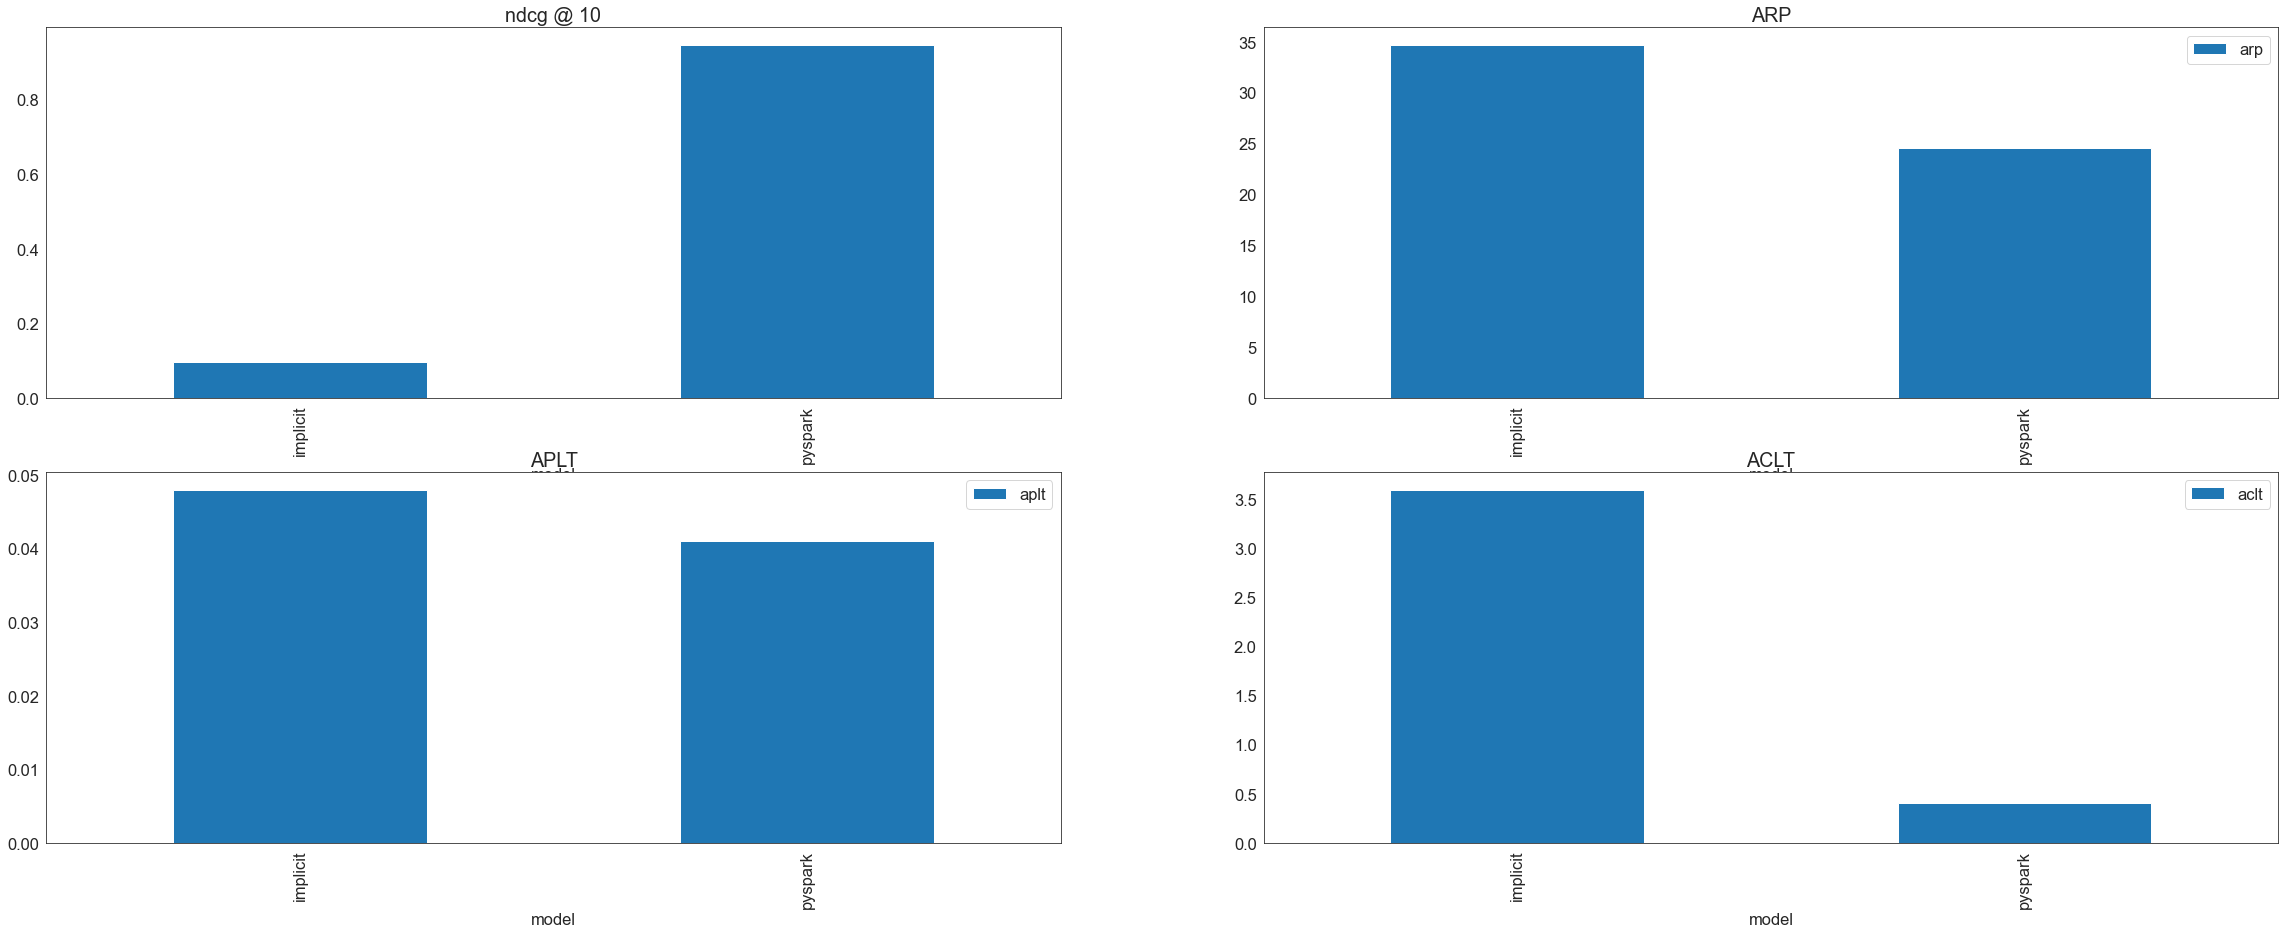

In [80]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(40,15))

results.groupby('model').ndcg.mean().plot(ax= axes[0,0], kind='bar'); axes[0,0].set_title('ndcg @ 10')

results.plot(ax=axes[0, 1], kind='bar', x= 'model', y ='arp'); axes[0,1].set_title('ARP')

results.plot(ax=axes[1,0], kind='bar', x= 'model', y ='aplt'); axes[1,0].set_title('APLT')

results.plot(ax=axes[1,1], kind='bar', x= 'model', y ='aclt'); axes[1,1].set_title('ACLT')
fig.figure.savefig('./figs/results-pyspark-and-implicit.png')